# Named Entity Recognition in NLP

## Importing necessary libraries

In [ ]:
!pip install transformers

In [ ]:
!pip install networkx

In [1]:
!pip install -U transformers
!pip install -U accelerate
!pip install -U datasets

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 297.6/297.6 kB 5.9 MB/s eta 0:00:00
  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (23.7 MB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (823 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (14.1 MB)
  Using cached nvidia_cudnn_cu12-8.9.2.26-py3-none-manylinux1_x86_64.whl (731.7 MB)
  Using cached nvidia_cublas_cu12-12.1.3.1-py3-none-manylinux1_x86_64.whl (410.6 MB)
  Using cached nvidia_cufft_cu12-11.0.2.54-py3-none-manylinux1_x86_64.whl (121.6 MB)
  Using cached nvidia_curand_cu12-10.3.2.106-py3-none-manylinux1_x86_64.whl (56.5 MB)
  Using cached nvidia_cusolver_cu12-11.4.5.107-py3-none-manylinux1_x86_64.whl (124.2 MB)
  Using cached nvidia_cusparse_cu12-12.1.0.106-py3-none-manylinux1_x86_64.whl (196.0 MB)
  Using cached nvidia_nccl_cu12-2.19.3-py3-none-manylinux1_x86_64.whl (166.0 MB)
  Using cached nvidia_nvtx_cu12-12.1.105-py3-none-many

In [ ]:
import torch
# PyTorch, a library for tensor operations and building neural networks.

from transformers import BertTokenizerFast, BertForTokenClassification
# Provides BERT tokenizer and token classification model for NER tasks.

from torch.utils.data import DataLoader
# Tool for batching and iterating over a dataset efficiently.

from transformers import AdamW
# Adam optimizer with weight decay, for training deep learning models.

from tqdm import tqdm

## Datasets

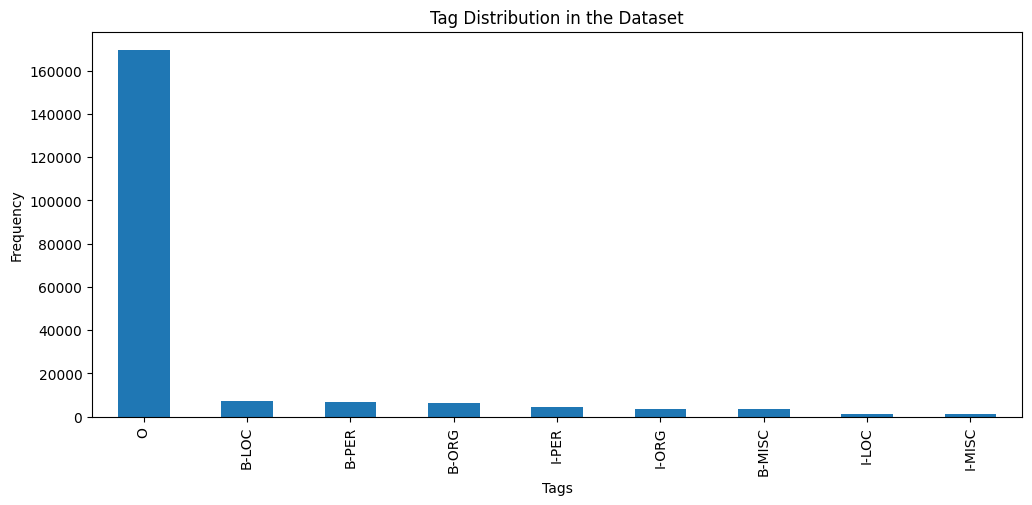

Number of training sentences: 946
Number of unique words in training set: 23623
Number of unique tags in training set: 9


In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

def load_dataset(file_path):
    with open(file_path, 'r', encoding='utf-8') as file:
        lines = [line.strip() for line in file if line.strip()]
    sentences, words, tags = [], [], []
    for line in lines:
        if line.startswith("-DOCSTART-"):
            sentences.append([])
        else:
            word_info = line.split()
            if len(word_info) == 4:
                word, pos, chunk, tag = word_info
                words.append(word)
                tags.append(tag)
                sentences[-1].append((word, tag))
    return sentences, words, tags

def visualize_data_distribution(tags):
    tag_counts = pd.Series(tags).value_counts()
    plt.figure(figsize=(12,5))
    tag_counts.plot(kind='bar')
    plt.title('Tag Distribution in the Dataset')
    plt.xlabel('Tags')
    plt.ylabel('Frequency')
    plt.xticks(rotation=90)
    plt.show()

# Paths to the data files
train_path = 'train.txt'
valid_path = 'valid.txt'
test_path = 'test.txt'

# Loading the datasets
train_sentences, train_words, train_tags = load_dataset(train_path)
valid_sentences, valid_words, valid_tags = load_dataset(valid_path)
test_sentences, test_words, test_tags = load_dataset(test_path)

# Visualizing the tag distribution in the training set
visualize_data_distribution(train_tags)

# Printing out some basic dataset information
print(f'Number of training sentences: {len(train_sentences)}')
print(f'Number of unique words in training set: {len(set(train_words))}')
print(f'Number of unique tags in training set: {len(set(train_tags))}')

## labels representation

In [ ]:
def read_labels(file_path):
    labels = set()
    with open(file_path, 'r') as file:
        for line in file:
            parts = line.strip().split()
            # The NER tag is the last element on the line
            if len(parts) > 1:  # This checks that it's not an empty line
                labels.add(parts[-1])  # Add the NER tag to the set
    return labels

# Reading labels from the dataset
train_labels = read_labels('train.txt')
valid_labels = read_labels('valid.txt')
test_labels = read_labels('test.txt')

# Combining all labels to get the unique ones
all_labels = set(list(train_labels) + list(valid_labels) + list(test_labels))
num_labels = len(all_labels)  # This should now give you the correct number of unique labels

print(f'Number of unique labels: {num_labels}')
print('All the Labels : ',all_labels)

Number of unique labels: 9
All the Labels :  {'I-MISC', 'I-ORG', 'I-PER', 'I-LOC', 'B-PER', 'B-LOC', 'O', 'B-MISC', 'B-ORG'}


#Label Interpretation:

###The Unique Labels in my dataset are:

###O: Non-entity, used for tokens that are not part of a named entity.
###B-LOC: Beginning of a location name.
###I-LOC: Token inside a location name.
###B-MISC: Beginning of a miscellaneous entity that does not belong to the pre-defined categories of locations, organizations, or person names.
###I-MISC: Token inside a miscellaneous entity.
###B-ORG: Beginning of an organization name.
###I-ORG: Token inside an organization name.
###B-PER: Beginning of a person's name.
###I-PER: Token inside a person's name.**

## Tokenizer Setup

In [ ]:
#setting device to cuda to use GPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

tokenizer = BertTokenizerFast.from_pretrained('bert-base-uncased')
model = BertForTokenClassification.from_pretrained('bert-base-uncased', num_labels=num_labels)

model.to(device)

Some weights of BertForTokenClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


BertForTokenClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, el

## Define the Custom Dataset Class

In [ ]:
from torch.utils.data import Dataset
import torch

class NERDataset(Dataset):
    def __init__(self, tokenizer, file_path, tag_map):
        self.tokenizer = tokenizer
        self.sentences = []
        self.labels = []

        with open(file_path, 'r') as f:
            sentence = []
            label = []
            for line in f:
                line = line.strip()
                if len(line)==0 or line.startswith('-DOCSTART') or line[0]=="\n":  # New sentence
                    if sentence:
                        self.sentences.append(sentence)
                        self.labels.append(label)
                        sentence = []
                        label = []
                else:
                    parts = line.split()
                    if len(parts) > 2:  # This handles cases where the token itself contains spaces
                        token = " ".join(parts[:1])  # Join all but the last part
                        tag = parts[-1]  # The last part is the tag
                    else:
                        token, tag = parts
                    sentence.append(token)
                    label.append(tag_map[tag])
            # Catch the last sentence if the file doesn't end with a newline
            if sentence:
                self.sentences.append(sentence)
                self.labels.append(label)
        self.tag_map = tag_map

    def __len__(self):
        return len(self.sentences)

    def __getitem__(self, idx):
        sentence = self.sentences[idx]
        label = self.labels[idx]
        encoding = self.tokenizer(
            sentence,
            is_split_into_words=True,
            padding='max_length',
            truncation=True,
            max_length=128,
            return_tensors="pt"
        )

        # Create a new labels tensor with -100 (ignore index) for padding
        label_tensor = torch.full((128,), fill_value=-100, dtype=torch.long)

        # Set labels for the `max_length` first tokens, including the [CLS] token
        label_tensor[1:len(label) + 1] = torch.LongTensor(label)

        # Add the [SEP] token at the end
        label_tensor[len(label) + 1] = self.tag_map["O"]


        encoding['labels'] = label_tensor

        return {key: tensor.squeeze(0) for key, tensor in encoding.items()}

In [ ]:
# Create a dictionary mapping each label in all_labels to a unique integer.
# all_labels is sorted, and each label is paired with an index using enumerate.
tag_map = {tag: idx for idx, tag in enumerate(sorted(all_labels))}

In [ ]:
# Create datasets
train_dataset = NERDataset(tokenizer, 'train.txt', tag_map)
valid_dataset = NERDataset(tokenizer, 'valid.txt', tag_map)
test_dataset = NERDataset(tokenizer, 'test.txt', tag_map)

In [ ]:
print("Tag Map:", tag_map)

Tag Map: {'B-LOC': 0, 'B-MISC': 1, 'B-ORG': 2, 'B-PER': 3, 'I-LOC': 4, 'I-MISC': 5, 'I-ORG': 6, 'I-PER': 7, 'O': 8}


In [ ]:
train_dataset.sentences[0]

['EU', 'rejects', 'German', 'call', 'to', 'boycott', 'British', 'lamb', '.']

In [ ]:
# Display tokenization and label shape for a sample
sample_sentence = train_dataset.sentences[0]
sample_label = train_dataset.labels[0]  # Use the labels corresponding to the first sentence

# Convert all integer labels in sample_label to their string representations using the reverse of tag_map
int_to_str_tag_map = {idx: tag for tag, idx in tag_map.items()}
sample_label = [int_to_str_tag_map[tag] if isinstance(tag, int) else tag for tag in sample_label]

print("Original Sentence:", sample_sentence)
print("Original Labels:", sample_label)

sample_encoding = tokenizer(
    sample_sentence,
    is_split_into_words=True,
    padding='max_length',
    truncation=True,
    max_length=128,
    return_tensors="pt"
)

# Ensure all elements in sample_label are strings
assert all(isinstance(tag, str) for tag in sample_label), "Labels should be strings."

# Create the label tensor using string tags
sample_label_tensor = torch.full((128,), fill_value=-100, dtype=torch.long)
sample_label_tensor[1:len(sample_label) + 1] = torch.LongTensor(
    [tag_map[tag] for tag in sample_label]
)

print("Tokenized Input IDs:", sample_encoding['input_ids'])
print("Input IDs Shape:", sample_encoding['input_ids'].shape)
print("Label Tensor:", sample_label_tensor)
print("Label Tensor Shape:", sample_label_tensor.shape)

Original Sentence: ['EU', 'rejects', 'German', 'call', 'to', 'boycott', 'British', 'lamb', '.']
Original Labels: ['B-ORG', 'O', 'B-MISC', 'O', 'O', 'O', 'B-MISC', 'O', 'O']
Tokenized Input IDs: tensor([[  101,  7327, 19164,  2446,  2655,  2000, 17757,  2329, 12559,  1012,
           102,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0, 

In [ ]:
# Create the DataLoaders for iterating over the full datasets
# DataLoader for the full training dataset, with a batch size of 8 samples and shuffling enabled to randomize the order of samples.
train_loader = DataLoader(train_dataset, batch_size=8, shuffle=True)

# DataLoader for the full validation dataset, with a batch size of 8 samples, no shuffling is typically needed for validation.
valid_loader = DataLoader(valid_dataset, batch_size=8)

# DataLoader for the full testing dataset, with a batch size of 8 samples, no shuffling is typically needed for testing.
test_loader = DataLoader(test_dataset, batch_size=8)

In [ ]:
optimizer = AdamW(model.parameters(), lr=5e-5)

/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:521: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


In [ ]:
print(f"Total number of training batches: {len(train_loader)}")
print(f"Total number of validation batches: {len(valid_loader)}")
print(f"Total number of testing batches: {len(test_loader)}")

Total number of training batches: 1756
Total number of validation batches: 407
Total number of testing batches: 432


## BERT training loop

In [ ]:
from transformers import get_linear_schedule_with_warmup
from sklearn.metrics import accuracy_score, precision_recall_fscore_support
import numpy as np

epochs = 3
total_steps = len(train_loader) * epochs

# Create the learning rate scheduler.
scheduler = get_linear_schedule_with_warmup(optimizer,
                                            num_warmup_steps=0,
                                            num_training_steps=total_steps)

# Define the function to calculate the evaluation metrics
def calculate_metrics(preds, labels):
    preds_flat = np.argmax(preds, axis=2).flatten()
    labels_flat = labels.flatten()
    # Only calculate metrics for non-ignored labels
    valid_indices = labels_flat != -100
    preds_flat = preds_flat[valid_indices]
    labels_flat = labels_flat[valid_indices]
    accuracy = accuracy_score(labels_flat, preds_flat)
    precision, recall, f1, _ = precision_recall_fscore_support(labels_flat, preds_flat, average='macro')
    return accuracy, precision, recall, f1

# Training and validation loop
for epoch in range(epochs):
    # Training step
    model.train()
    total_loss = 0
    for batch in tqdm(train_loader, desc=f"Training Epoch {epoch}"):
        batch = {k: v.to(device) for k, v in batch.items()}

        model.zero_grad()
        outputs = model(**batch)

        loss = outputs.loss
        total_loss += loss.item()

        loss.backward()
        optimizer.step()
        scheduler.step()

    avg_train_loss = total_loss / len(train_loader)
    print(f"Average training loss: {avg_train_loss:.2f}")

    # Validation step
    model.eval()
    val_loss = 0
    predictions, true_labels = [], []

    for batch in tqdm(valid_loader, desc=f"Validation Epoch {epoch}"):
        batch = {k: v.to(device) for k, v in batch.items()}
        with torch.no_grad():
            outputs = model(**batch)

        loss = outputs.loss
        val_loss += loss.item()

        logits = outputs.logits.detach().cpu().numpy()
        label_ids = batch['labels'].cpu().numpy()

        predictions.extend(logits)
        true_labels.extend(label_ids)

    avg_val_loss = val_loss / len(valid_loader)
    accuracy, precision, recall, f1 = calculate_metrics(np.array(predictions), np.array(true_labels))

    print(f"Validation loss: {avg_val_loss:.2f}")
    print(f"Validation Accuracy: {accuracy:.2f}")
    print(f"Validation Precision: {precision:.2f}")
    print(f"Validation Recall: {recall:.2f}")
    print(f"Validation F1-Score: {f1:.2f}")

Training Epoch 0: 100%|██████████| 1756/1756 [05:24<00:00,  5.42it/s]


Average training loss: 0.30


Validation Epoch 0: 100%|██████████| 407/407 [00:24<00:00, 16.48it/s]


Validation loss: 0.19
Validation Accuracy: 0.93
Validation Precision: 0.77
Validation Recall: 0.70
Validation F1-Score: 0.73


Training Epoch 1: 100%|██████████| 1756/1756 [05:25<00:00,  5.40it/s]


Average training loss: 0.14


Validation Epoch 1: 100%|██████████| 407/407 [00:24<00:00, 16.50it/s]


Validation loss: 0.15
Validation Accuracy: 0.94
Validation Precision: 0.84
Validation Recall: 0.74
Validation F1-Score: 0.78


Training Epoch 2: 100%|██████████| 1756/1756 [05:24<00:00,  5.41it/s]


Average training loss: 0.08


Validation Epoch 2: 100%|██████████| 407/407 [00:24<00:00, 16.50it/s]

Validation loss: 0.13
Validation Accuracy: 0.95
Validation Precision: 0.84
Validation Recall: 0.79
Validation F1-Score: 0.82


## Connecting to google drive to store model

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
model.save_pretrained('/content/drive/MyDrive/data NLP690/my_bert_model')

## Model Evaluation

In [ ]:
# Test the model to evaluate its performance
model.eval()  # put model in evaluation mode
test_loss, test_accuracy, test_precision, test_recall, test_f1 = 0, 0, 0, 0, 0

# No need to track gradients for validation
with torch.no_grad():
    for batch in tqdm(test_loader, desc="Testing"):
        # Transfer to GPU
        batch = {k: v.to(device) for k, v in batch.items()}

        # Forward pass
        outputs = model(**batch)

        # Compute loss
        loss = outputs.loss
        test_loss += loss.item()

        # Get the predictions
        logits = outputs.logits.detach().cpu().numpy()
        label_ids = batch['labels'].cpu().numpy()

        # Calculate the evaluation metrics
        batch_accuracy, batch_precision, batch_recall, batch_f1 = calculate_metrics(logits, label_ids)
        test_accuracy += batch_accuracy
        test_precision += batch_precision
        test_recall += batch_recall
        test_f1 += batch_f1

# Compute the average loss and average metrics
avg_test_loss = test_loss / len(test_loader)
avg_test_accuracy = test_accuracy / len(test_loader)
avg_test_precision = test_precision / len(test_loader)
avg_test_recall = test_recall / len(test_loader)
avg_test_f1 = test_f1 / len(test_loader)

print(f"Test loss: {avg_test_loss:.2f}")
print(f"Test Accuracy: {avg_test_accuracy:.2f}")
print(f"Test Precision: {avg_test_precision:.2f}")
print(f"Test Recall: {avg_test_recall:.2f}")
print(f"Test F1-Score: {avg_test_f1:.2f}")

Testing:   2%|▏         | 10/432 [00:00<00:26, 16.18it/s]/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Testing:   3%|▎         | 12/432 [00:00<00:25, 16.33it/s]/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Testing:   3%|▎         | 14/432 [00:00<00:25, 16.43it/s]/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` paramete

Test loss: 0.21
Test Accuracy: 0.95
Test Precision: 0.80
Test Recall: 0.79
Test F1-Score: 0.78


In [ ]:
!pip install torchcrf

In [ ]:
#Imports
import torch
import torch.nn as nn
import torch.optim as optim
import os
from tqdm import tqdm

## Define BiLSTM

In [ ]:
#BiLSTMForTokenClassification Model Definition
class BiLSTMForTokenClassification(nn.Module):
    def __init__(self, num_labels, hidden_size=128, num_layers=2, dropout=0.1):
        super(BiLSTMForTokenClassification, self).__init__()
        self.embedding = nn.Embedding(tokenizer.vocab_size, hidden_size)
        self.bilstm = nn.LSTM(hidden_size, hidden_size, num_layers=num_layers, bidirectional=True, batch_first=True)
        self.dropout = nn.Dropout(dropout)
        self.fc = nn.Linear(2 * hidden_size, num_labels)

    def forward(self, input_ids):
        embeddings = self.embedding(input_ids)
        embeddings = self.dropout(embeddings)
        lstm_output, _ = self.bilstm(embeddings)
        logits = self.fc(lstm_output)
        return logits

In [ ]:
#Model Instantiation and Optimizer
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
bilstm_model = BiLSTMForTokenClassification(num_labels=num_labels)
bilstm_model.to(device)
bilstm_optimizer = optim.AdamW(bilstm_model.parameters(), lr=5e-5)
bilstm_scheduler = torch.optim.lr_scheduler.StepLR(bilstm_optimizer, step_size=10, gamma=0.5)

## BiLSTM Training loop

In [ ]:
# Training Loop
epochs = 3
bilstm_model.train()
for epoch in range(epochs):
    total_loss = 0
    for batch in tqdm(train_loader, desc=f"Training Epoch {epoch}"):
        input_ids = batch['input_ids'].to(device)
        labels = batch['labels'].to(device)

        bilstm_optimizer.zero_grad()
        logits = bilstm_model(input_ids)

        loss_fn = nn.CrossEntropyLoss()
        loss = loss_fn(logits.view(-1, num_labels), labels.view(-1))
        total_loss += loss.item()

        loss.backward()
        bilstm_optimizer.step()
        bilstm_scheduler.step()

    avg_train_loss = total_loss / len(train_loader)
    print(f"Average training loss: {avg_train_loss:.2f}")

Training Epoch 0: 100%|██████████| 1756/1756 [00:13<00:00, 130.00it/s]


Average training loss: 2.07


Training Epoch 1: 100%|██████████| 1756/1756 [00:13<00:00, 128.39it/s]


Average training loss: 2.07


Training Epoch 2: 100%|██████████| 1756/1756 [00:12<00:00, 139.61it/s]

Average training loss: 2.07


## BiLSTM Validation

In [ ]:
#BiLSTM Evaluation Loop
from sklearn.metrics import f1_score, accuracy_score
import numpy as np

# Function to calculate the accuracy of our predictions vs labels
def flat_accuracy(preds, labels):
    pred_flat = np.argmax(preds, axis=1).flatten()
    labels_flat = labels.flatten()
    return np.sum(pred_flat == labels_flat) / len(labels_flat)

# Function to calculate metrics for all batches
def compute_metrics(predictions, true_labels):
    # Flatten all the predictions and true values
    predictions = np.concatenate(predictions, axis=0)
    true_labels = np.concatenate(true_labels, axis=0)

    # Only evaluate on non-ignored indices (-100 is used for ignored)
    valid_indices = true_labels != -100
    predictions = predictions[valid_indices]
    true_labels = true_labels[valid_indices]

    f1 = f1_score(true_labels, predictions, average='macro')
    accuracy = accuracy_score(true_labels, predictions)

    return f1, accuracy

# Place the model in evaluation mode
bilstm_model.eval()

# Initialize lists to gather full prediction and label sets
all_predictions, all_labels = [], []

# Evaluate data for one epoch
for batch in tqdm(valid_loader, desc="Evaluating"):
    # Add batch to device
    batch = {k: v.to(device) for k, v in batch.items()}

    # Telling the model not to compute or store gradients
    with torch.no_grad():
        # Forward pass, calculate logit predictions
        outputs = bilstm_model(batch['input_ids'])

    # Move logits and labels to CPU
    logits = outputs.detach().cpu().numpy()
    label_ids = batch['labels'].to('cpu').numpy()

    # Store predictions and true labels
    all_predictions.extend([list(p) for p in np.argmax(logits, axis=2)])
    all_labels.extend([list(l) for l in label_ids])

# Calculate metrics
f1, accuracy = compute_metrics(all_predictions, all_labels)

print(f"Validation F1-Score: {f1:.2f}")
print(f"Validation Accuracy: {accuracy:.2f}")

Evaluating: 100%|██████████| 407/407 [00:02<00:00, 173.68it/s]

Validation F1-Score: 0.10
Validation Accuracy: 0.84


In [ ]:
from sklearn.metrics import precision_score, recall_score

def compute_metrics(predictions, true_labels):
    # Flatten all the predictions and true values
    predictions = np.concatenate(predictions, axis=0)
    true_labels = np.concatenate(true_labels, axis=0)

    # Only evaluate on non-ignored indices (-100 is used for ignored)
    valid_indices = true_labels != -100
    predictions = predictions[valid_indices]
    true_labels = true_labels[valid_indices]

    f1 = f1_score(true_labels, predictions, average='macro')
    accuracy = accuracy_score(true_labels, predictions)
    precision = precision_score(true_labels, predictions, average='macro')
    recall = recall_score(true_labels, predictions, average='macro')

    return f1, accuracy, precision, recall

# Place the model in evaluation mode
bilstm_model.eval()

# Initialize lists to gather full prediction and label sets
all_predictions, all_labels = [], []

# Evaluate data for one epoch
for batch in tqdm(valid_loader, desc="Evaluating"):
    # Add batch to device
    batch = {k: v.to(device) for k, v in batch.items()}

    # Telling the model not to compute or store gradients
    with torch.no_grad():
        # Forward pass, calculate logit predictions
        outputs = bilstm_model(batch['input_ids'])

    # Move logits and labels to CPU
    logits = outputs.detach().cpu().numpy()
    label_ids = batch['labels'].to('cpu').numpy()

    # Store predictions and true labels
    all_predictions.extend([list(p) for p in np.argmax(logits, axis=2)])
    all_labels.extend([list(l) for l in label_ids])

# Calculate metrics
f1, accuracy, precision, recall = compute_metrics(all_predictions, all_labels)

print(f"Validation F1-Score: {f1:.2f}")
print(f"Validation Accuracy: {accuracy:.2f}")
print(f"Validation Precision: {precision:.2f}")
print(f"Validation Recall: {recall:.2f}")


Evaluating: 100%|██████████| 407/407 [00:02<00:00, 165.69it/s]


Validation F1-Score: 0.10
Validation Accuracy: 0.84
Validation Precision: 0.09
Validation Recall: 0.11


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


## Storing the Bi-LSTM model

In [ ]:
# Save the entire model
torch.save(bilstm_model, '/content/drive/MyDrive/data NLP690/my_bilstm_model.pth')

print('Model saved to /content/drive/MyDrive/data NLP690/my_bilstm_model.pth')

Model saved to /content/drive/MyDrive/data NLP690/my_bilstm_model.pth


In [ ]:
!pip install torchinfo

## Model Summaries

## BERT model Summary

In [ ]:
from torchinfo import summary

# Assuming your model variable holds the BertForTokenClassification model
# and that you have a batch of data available in input_ids
# We will create a batch of dummy data with two input sequences for the purpose of model summary
input_ids = tokenizer(['Hello, this is a test.', 'Here is another sentence.'],
                      padding=True, truncation=True, max_length=128, return_tensors="pt").input_ids

# Move the tensor to the appropriate device
input_ids = input_ids.to(device)

# Use torchinfo to print the summary
bert_model_summary = summary(model, input_data=(input_ids,), verbose=0)  # You can set verbose to 1 for more detail
print(bert_model_summary)

We strongly recommend passing in an `attention_mask` since your input_ids may be padded. See https://huggingface.co/docs/transformers/troubleshooting#incorrect-output-when-padding-tokens-arent-masked.


Layer (type:depth-idx)                                  Output Shape              Param #
BertForTokenClassification                              [2, 9, 9]                 --
├─BertModel: 1-1                                        [2, 9, 768]               --
│    └─BertEmbeddings: 2-1                              [2, 9, 768]               --
│    │    └─Embedding: 3-1                              [2, 9, 768]               23,440,896
│    │    └─Embedding: 3-2                              [2, 9, 768]               1,536
│    │    └─Embedding: 3-3                              [1, 9, 768]               393,216
│    │    └─LayerNorm: 3-4                              [2, 9, 768]               1,536
│    │    └─Dropout: 3-5                                [2, 9, 768]               --
│    └─BertEncoder: 2-2                                 [2, 9, 768]               --
│    │    └─ModuleList: 3-6                             --                        85,054,464
├─Dropout: 1-2                   

## Bi-LSTM Model Summary

In [ ]:
import torch
from torchinfo import summary

# Load the BiLSTM model
bilstm_model = torch.load('/content/drive/MyDrive/data NLP690/my_bilstm_model.pth')

# Assuming the BiLSTM expects the same input_ids as the BERT model
# Generate BiLSTM model summary
bilstm_model_summary = summary(bilstm_model, input_data=(input_ids.to(device),), verbose=0)
print(bilstm_model_summary)

Layer (type:depth-idx)                   Output Shape              Param #
BiLSTMForTokenClassification             [2, 9, 9]                 --
├─Embedding: 1-1                         [2, 9, 128]               3,906,816
├─Dropout: 1-2                           [2, 9, 128]               --
├─LSTM: 1-3                              [2, 9, 256]               659,456
├─Linear: 1-4                            [2, 9, 9]                 2,313
Total params: 4,568,585
Trainable params: 4,568,585
Non-trainable params: 0
Total mult-adds (M): 19.69
Input size (MB): 0.00
Forward/backward pass size (MB): 0.06
Params size (MB): 18.27
Estimated Total Size (MB): 18.33


## model predictions for BERT and BiLSTM

In [ ]:
# Load the trained BERT-based model (if not already loaded)
from transformers import BertForTokenClassification

bert_model = BertForTokenClassification.from_pretrained('/content/drive/MyDrive/data NLP690/my_bert_model')

# Load the trained BiLSTM-based model (if not already loaded)
# Assuming you have previously saved it using torch.save
import torch

bilstm_model = torch.load('/content/drive/MyDrive/data NLP690/my_bilstm_model.pth')

## Bert Predictions

In [ ]:
input_text = "Radha and Ahmed lives in New York City in US"

# Define a function to make predictions using the BERT-based model
def predict_with_bert_model(model, text):
    # Tokenize the input text
    inputs = tokenizer(text, padding=True, truncation=True, max_length=128, return_tensors="pt")

    # Forward pass through the model
    with torch.no_grad():
        outputs = model(**inputs)

    # Get the predicted labels
    predicted_labels = np.argmax(outputs.logits, axis=2).tolist()[0]

    # Map label IDs to tag names
    predicted_tags = [int_to_str_tag_map[label_id] for label_id in predicted_labels]

    # Get the tokens from the input text
    tokens = tokenizer.convert_ids_to_tokens(inputs["input_ids"][0])

    # Print the tokens along with their predicted tags
    for token,label_id,tag in zip(tokens,predicted_labels,predicted_tags):
        print(f"Token: {token.ljust(15)}| Predicted Label: {label_id} | Predicted Tag: {tag}")

# Make predictions using the BERT-based model
predict_with_bert_model(bert_model, input_text)


Token: [CLS]          | Predicted Label: 8 | Predicted Tag: O
Token: radha          | Predicted Label: 3 | Predicted Tag: B-PER
Token: and            | Predicted Label: 8 | Predicted Tag: O
Token: ahmed          | Predicted Label: 3 | Predicted Tag: B-PER
Token: lives          | Predicted Label: 8 | Predicted Tag: O
Token: in             | Predicted Label: 8 | Predicted Tag: O
Token: new            | Predicted Label: 0 | Predicted Tag: B-LOC
Token: york           | Predicted Label: 4 | Predicted Tag: I-LOC
Token: city           | Predicted Label: 4 | Predicted Tag: I-LOC
Token: in             | Predicted Label: 8 | Predicted Tag: O
Token: us             | Predicted Label: 0 | Predicted Tag: B-LOC
Token: [SEP]          | Predicted Label: 8 | Predicted Tag: O


## Bi-LSTM Predictions

In [ ]:
import torch

def predict_with_bilstm_model(model, text):
    # Tokenize the input text
    inputs = tokenizer(text, padding=True, truncation=True, max_length=128, return_tensors="pt")

    # Move the inputs to the appropriate device
    input_ids = inputs['input_ids'].to(model.embedding.weight.device)  # Use the device of the embedding layer

    # Forward pass through the model
    with torch.no_grad():
        logits = model(input_ids)

    # Get the predicted labels
    predicted_labels = torch.argmax(logits, dim=2).squeeze().tolist()
    return predicted_labels

# Example usage:
input_text = "Ahmed lives in New York City in US"
bilstm_predictions = predict_with_bilstm_model(bilstm_model, input_text)
print(input_text)

print("BiLSTM Predictions:", bilstm_predictions)

Ahmed lives in New York City in US
BiLSTM Predictions: [8, 8, 8, 8, 8, 8, 8, 8, 8, 8]


Bi-LSTM and BERT predictions side by side

In [ ]:
def predict_bert(model, tokenizer, sentence):
    # Tokenize the input sentence
    inputs = tokenizer(sentence, padding=True, truncation=True, max_length=128, return_tensors="pt")

    # Move tensors to the appropriate device
    inputs = {k: v.to(device) for k, v in inputs.items()}

    # Put the model in evaluation mode and disable gradient calculation
    model.eval()
    with torch.no_grad():
        outputs = model(**inputs)

    # Get the logits and apply softmax to get probabilities
    logits = outputs.logits
    probabilities = torch.nn.functional.softmax(logits, dim=-1)
    predictions = torch.argmax(probabilities, dim=-1)

    return predictions[0].cpu().numpy()

In [ ]:
def predict_bilstm(model, tokenizer, sentence):
    # Tokenize the input sentence
    inputs = tokenizer(sentence, padding=True, truncation=True, max_length=128, return_tensors="pt")

    # Extract input_ids and move to the appropriate device
    input_ids = inputs['input_ids'].to(device)

    # Put the model in evaluation mode and disable gradient calculation
    model.eval()
    with torch.no_grad():
        logits = model(input_ids)

    # Apply softmax to get probabilities and then get predictions
    probabilities = torch.nn.functional.softmax(logits, dim=-1)
    predictions = torch.argmax(probabilities, dim=-1)

    return predictions[0].cpu().numpy()

In [ ]:
sentence = "Rishi Dasari stays in london UK."
bert_predictions = predict_bert(model, tokenizer, sentence)
bilstm_predictions = predict_bilstm(bilstm_model, tokenizer, sentence)

# Convert predictions to tag names
bert_tags = [int_to_str_tag_map[p] for p in bert_predictions]
bilstm_tags = [int_to_str_tag_map[p] for p in bilstm_predictions]

print("BERT Predictions:", bert_tags[1:-1])
print("BiLSTM Predictions:", bilstm_tags)

BERT Predictions: ['B-PER', 'I-PER', 'O', 'O', 'B-LOC', 'I-LOC', 'O', 'O', 'O']
BiLSTM Predictions: ['O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O']


###The reason for Bi-LSTM having more accuracy and less F1 Score is because of skewed 'O' tags.

### BERTBiLSTM model

In [ ]:
import torch
import torch.nn as nn
from transformers import BertModel, BertTokenizerFast

# Define a class for the combined BERT-BiLSTM model
class BertBiLSTM(nn.Module):
    def __init__(self, num_labels, bert_model_name='bert-base-uncased', hidden_size=128, num_layers=2, dropout=0.1):
        super(BertBiLSTM, self).__init__()

        # BERT model for feature extraction
        self.bert = BertModel.from_pretrained(bert_model_name)

        # BiLSTM layer
        self.bilstm = nn.LSTM(self.bert.config.hidden_size, hidden_size, num_layers=num_layers, bidirectional=True, batch_first=True)

        # Dropout layer
        self.dropout = nn.Dropout(dropout)

        # Classification layer
        self.fc = nn.Linear(2 * hidden_size, num_labels)

    def forward(self, input_ids, attention_mask):
        # BERT forward pass
        bert_output = self.bert(input_ids=input_ids, attention_mask=attention_mask)[0]

        # BiLSTM forward pass
        lstm_output, _ = self.bilstm(bert_output)

        # Apply dropout
        lstm_output = self.dropout(lstm_output)

        # Classification layer
        logits = self.fc(lstm_output)

        return logits

# Example usage:
# Initialize the combined model
num_labels = 10  # Number of output labels
combined_model = BertBiLSTM(num_labels=num_labels)

# Example input text
input_text = "Ahmed lives in New York City in US"
tokenizer = BertTokenizerFast.from_pretrained('bert-base-uncased')
inputs = tokenizer(input_text, padding=True, truncation=True, max_length=128, return_tensors='pt')

# Forward pass through the combined model
logits = combined_model(inputs.input_ids, inputs.attention_mask)

# Get the predicted labels
predicted_labels = torch.argmax(logits, dim=2).squeeze().tolist()

print("Input Text:", input_text)
print("Predicted Labels:", predicted_labels)


Input Text: Ahmed lives in New York City in US
Predicted Labels: [2, 2, 2, 2, 7, 2, 2, 9, 9, 9]


In [ ]:
import torch
import torch.nn as nn
from transformers import BertModel, BertTokenizerFast

# Define a class for the combined BERT-BiLSTM model
class BertBiLSTM(nn.Module):
    def __init__(self, num_labels, bert_model_name='bert-base-uncased', hidden_size=128, num_layers=2, dropout=0.1):
        super(BertBiLSTM, self).__init__()

        # BERT model for feature extraction
        self.bert = BertModel.from_pretrained(bert_model_name)

        # BiLSTM layer
        self.bilstm = nn.LSTM(self.bert.config.hidden_size, hidden_size, num_layers=num_layers, bidirectional=True, batch_first=True)

        # Dropout layer
        self.dropout = nn.Dropout(dropout)

        # Classification layer
        self.fc = nn.Linear(2 * hidden_size, num_labels)

    def forward(self, input_ids, attention_mask):
        # BERT forward pass
        bert_output = self.bert(input_ids=input_ids, attention_mask=attention_mask)[0]

        # BiLSTM forward pass
        lstm_output, _ = self.bilstm(bert_output)

        # Apply dropout
        lstm_output = self.dropout(lstm_output)

        # Classification layer
        logits = self.fc(lstm_output)

        return logits

# Function to map predicted labels to tag map
def map_labels_to_tags(predicted_labels, tag_map):
    return [tag_map[label] for label in predicted_labels]

# Example usage:
# Initialize the combined model
num_labels = 10  # Number of output labels
combined_model = BertBiLSTM(num_labels=num_labels)

# Example input text
input_text = "Ahmed lives in New York City in US"
tokenizer = BertTokenizerFast.from_pretrained('bert-base-uncased')
inputs = tokenizer(input_text, padding=True, truncation=True, max_length=128, return_tensors='pt')

# Forward pass through the combined model
logits = combined_model(inputs.input_ids, inputs.attention_mask)

# Get the predicted labels
predicted_labels = torch.argmax(logits, dim=2).squeeze().tolist()

# Define tag map
tag_map = {0: 'O', 1: 'B-LOC', 2: 'I-LOC', 3: 'B-PER', 4: 'I-PER', 5: 'B-ORG', 6: 'I-ORG', 7: 'B-MISC', 8: 'I-MISC', 9: 'X'}

# Map predicted labels to tags
predicted_tags = map_labels_to_tags(predicted_labels, tag_map)

print("Input Text:", input_text)
print("Predicted Tags:", predicted_tags)


Input Text: Ahmed lives in New York City in US
Predicted Tags: ['O', 'O', 'B-ORG', 'O', 'O', 'O', 'O', 'O', 'O', 'O']


Predictions were not so great either so didn't include in the paper.

## Fine tuned BERT
## DistilBERT from hugging face

In [2]:
import pandas as pd
from datasets import load_dataset

In [3]:
data = load_dataset('conllpp')
data

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


Generating train split:   0%|          | 0/14041 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/3250 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/3453 [00:00<?, ? examples/s]

DatasetDict({
    train: Dataset({
        features: ['id', 'tokens', 'pos_tags', 'chunk_tags', 'ner_tags'],
        num_rows: 14041
    })
    validation: Dataset({
        features: ['id', 'tokens', 'pos_tags', 'chunk_tags', 'ner_tags'],
        num_rows: 3250
    })
    test: Dataset({
        features: ['id', 'tokens', 'pos_tags', 'chunk_tags', 'ner_tags'],
        num_rows: 3453
    })
})

In [4]:
pd.DataFrame(data['train'][:])[['tokens', 'ner_tags']].iloc[0]

tokens      [EU, rejects, German, call, to, boycott, Briti...
ner_tags                          [3, 0, 7, 0, 0, 0, 7, 0, 0]
Name: 0, dtype: object

In [5]:
tags = data['train'].features['ner_tags'].feature

index2tag = {idx:tag for idx, tag in enumerate(tags.names)}
tag2index = {tag:idx for idx, tag in enumerate(tags.names)}

In [7]:
def create_tag_names(batch):
  tag_name = {'ner_tags_str': [tags.int2str(idx) for idx in batch['ner_tags']]}
  return tag_name

In [8]:
data = data.map(create_tag_names)

Map:   0%|          | 0/14041 [00:00<?, ? examples/s]

Map:   0%|          | 0/3250 [00:00<?, ? examples/s]

Map:   0%|          | 0/3453 [00:00<?, ? examples/s]

In [9]:
pd.DataFrame(data['train'][:])[['tokens', 'ner_tags', 'ner_tags_str']].iloc[0]

tokens          [EU, rejects, German, call, to, boycott, Briti...
ner_tags                              [3, 0, 7, 0, 0, 0, 7, 0, 0]
ner_tags_str            [B-ORG, O, B-MISC, O, O, O, B-MISC, O, O]
Name: 0, dtype: object

## Model building
### Tokenization

In [10]:
from transformers import AutoTokenizer

model_checkpoint = "distilbert-base-cased"
tokenizer = AutoTokenizer.from_pretrained(model_checkpoint)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/29.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/465 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/213k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/436k [00:00<?, ?B/s]

In [11]:
tokenizer.is_fast

True

In [14]:
inputs = data['train'][0]['tokens']
inputs = tokenizer(inputs, is_split_into_words=True)
print(inputs.tokens())

['[CLS]', 'EU', 'rejects', 'German', 'call', 'to', 'boycott', 'British', 'la', '##mb', '.', '[SEP]']


In [12]:
print(data['train'][0]['tokens'])
print(data['train'][0]['ner_tags_str'])

['EU', 'rejects', 'German', 'call', 'to', 'boycott', 'British', 'lamb', '.']
['B-ORG', 'O', 'B-MISC', 'O', 'O', 'O', 'B-MISC', 'O', 'O']


In [15]:
inputs.word_ids()

[None, 0, 1, 2, 3, 4, 5, 6, 7, 7, 8, None]

In [16]:
def align_labels_with_tokens(labels, word_ids):
  new_labels = []
  current_word=None
  for word_id in word_ids:
    if word_id != current_word:
      current_word = word_id
      label = -100 if word_id is None else labels[word_id]
      new_labels.append(label)

    elif word_id is None:
      new_labels.append(-100)

    else:
      label = labels[word_id]

      if label%2==1:
        label = label + 1
      new_labels.append(label)

  return new_labels

In [17]:
labels = data['train'][0]['ner_tags']
word_ids = inputs.word_ids()
print(labels, word_ids)

[3, 0, 7, 0, 0, 0, 7, 0, 0] [None, 0, 1, 2, 3, 4, 5, 6, 7, 7, 8, None]


In [18]:
align_labels_with_tokens(labels, word_ids)

[-100, 3, 0, 7, 0, 0, 0, 7, 0, 0, 0, -100]

In [19]:
def tokenize_and_align_labels(examples):
  tokenized_inputs = tokenizer(examples['tokens'], truncation=True, is_split_into_words=True)

  all_labels = examples['ner_tags']

  new_labels = []
  for i, labels in enumerate(all_labels):
    word_ids = tokenized_inputs.word_ids(i)
    new_labels.append(align_labels_with_tokens(labels, word_ids))

  tokenized_inputs['labels'] = new_labels

  return tokenized_inputs

In [20]:
tokenized_datasets = data.map(tokenize_and_align_labels, batched=True, remove_columns=data['train'].column_names)

Map:   0%|          | 0/14041 [00:00<?, ? examples/s]

Asking to truncate to max_length but no maximum length is provided and the model has no predefined maximum length. Default to no truncation.


Map:   0%|          | 0/3250 [00:00<?, ? examples/s]

Map:   0%|          | 0/3453 [00:00<?, ? examples/s]

In [21]:
tokenized_datasets

DatasetDict({
    train: Dataset({
        features: ['input_ids', 'attention_mask', 'labels'],
        num_rows: 14041
    })
    validation: Dataset({
        features: ['input_ids', 'attention_mask', 'labels'],
        num_rows: 3250
    })
    test: Dataset({
        features: ['input_ids', 'attention_mask', 'labels'],
        num_rows: 3453
    })
})

Data Collation and metrices

In [22]:
from transformers import DataCollatorForTokenClassification

data_collator = DataCollatorForTokenClassification(tokenizer=tokenizer)

In [23]:
batch = data_collator([tokenized_datasets['train'][i] for i in range(2)])
batch

{'input_ids': tensor([[  101,  7270, 22961,  1528,  1840,  1106, 21423,  1418,  2495, 12913,
           119,   102],
        [  101,  1943, 14428,   102,     0,     0,     0,     0,     0,     0,
             0,     0]]), 'attention_mask': tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0]]), 'labels': tensor([[-100,    3,    0,    7,    0,    0,    0,    7,    0,    0,    0, -100],
        [-100,    1,    2, -100, -100, -100, -100, -100, -100, -100, -100, -100]])}

In [24]:
!pip install seqeval
!pip install evaluate

import evaluate
metric = evaluate.load('seqeval')

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.6/43.6 kB 1.5 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for seqeval: filename=seqeval-1.2.2-py3-none-any.whl size=16161 sha256=20718636d7023afb6c4f4de2c0fda2813fcbc6be6ac48cde679cefd1aa07aa91
  Stored in directory: /root/.cache/pip/wheels/1a/67/4a/ad4082dd7dfc30f2abfe4d80a2ed5926a506eb8a972b4767fa
Successfully built seqeval
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.1/84.1 kB 2.7 MB/s eta 0:00:00


In [25]:
ner_feature = data['train'].features['ner_tags']
ner_feature

Sequence(feature=ClassLabel(names=['O', 'B-PER', 'I-PER', 'B-ORG', 'I-ORG', 'B-LOC', 'I-LOC', 'B-MISC', 'I-MISC'], id=None), length=-1, id=None)

In [26]:
label_names = ner_feature.feature.names
label_names

['O', 'B-PER', 'I-PER', 'B-ORG', 'I-ORG', 'B-LOC', 'I-LOC', 'B-MISC', 'I-MISC']

In [27]:
labels = data['train'][0]['ner_tags']
labels = [label_names[i] for i in labels]
labels

['B-ORG', 'O', 'B-MISC', 'O', 'O', 'O', 'B-MISC', 'O', 'O']

In [28]:
predictions = labels.copy()
predictions[2] = "O"

metric.compute(predictions=[predictions], references=[labels])

{'MISC': {'precision': 1.0,
  'recall': 0.5,
  'f1': 0.6666666666666666,
  'number': 2},
 'ORG': {'precision': 1.0, 'recall': 1.0, 'f1': 1.0, 'number': 1},
 'overall_precision': 1.0,
 'overall_recall': 0.6666666666666666,
 'overall_f1': 0.8,
 'overall_accuracy': 0.8888888888888888}

In [29]:
import numpy as np

def compute_metrics(eval_preds):
  logits, labels = eval_preds

  predictions = np.argmax(logits, axis=-1)

  true_labels = [[label_names[l] for l in label if l!=-100] for label in labels]

  true_predictions = [[label_names[p] for p,l in zip(prediction, label) if l!=-100]
                      for prediction, label in zip(predictions, labels)]

  all_metrics = metric.compute(predictions=true_predictions, references=true_labels)

  return {"precision": all_metrics['overall_precision'],
          "recall": all_metrics['overall_recall'],
          "f1": all_metrics['overall_f1'],
          "accuracy": all_metrics['overall_accuracy']}

In [30]:
id2label = {i:label for i, label in enumerate(label_names)}
label2id = {label:i for i, label in enumerate(label_names)}

In [31]:
from transformers import AutoModelForTokenClassification

model = AutoModelForTokenClassification.from_pretrained(
                                                    model_checkpoint,
                                                    id2label=id2label,
                                                    label2id=label2id)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


model.safetensors:   0%|          | 0.00/263M [00:00<?, ?B/s]

Some weights of DistilBertForTokenClassification were not initialized from the model checkpoint at distilbert-base-cased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [36]:
model.config.num_labels

9

## DistilBERT Training and valuation

In [37]:
from transformers import TrainingArguments

args = TrainingArguments("distilbert-finetuned-ner",
                         evaluation_strategy = "epoch",
                         save_strategy="epoch",
                         learning_rate = 2e-5,
                         num_train_epochs=3,
                         weight_decay=0.01)

In [38]:
from transformers import Trainer
trainer = Trainer(model=model,
                  args=args,
                  train_dataset = tokenized_datasets['train'],
                  eval_dataset = tokenized_datasets['validation'],
                  data_collator=data_collator,
                  compute_metrics=compute_metrics,
                  tokenizer=tokenizer)

trainer.train()

Epoch,Training Loss,Validation Loss,Precision,Recall,F1,Accuracy
1,0.092900,0.086368,0.876619,0.911141,0.893547,0.975599
2,0.044600,0.074812,0.915908,0.931168,0.923475,0.981868
3,0.029000,0.070696,0.917036,0.939414,0.928090,0.983620


TrainOutput(global_step=5268, training_loss=0.0797268630160286, metrics={'train_runtime': 308.3723, 'train_samples_per_second': 136.598, 'train_steps_per_second': 17.083, 'total_flos': 460431563935266.0, 'train_loss': 0.0797268630160286, 'epoch': 3.0})

In [39]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## DistilBERT Predictions

In [46]:
from transformers import pipeline

# Define the directory to save the checkpoint
output_dir = "/content/drive/MyDrive/data NLP690/distil_bert"

# Save the model and tokenizer to the directory
trainer.save_model(output_dir)

# Load the model checkpoint using pipeline
token_classifier = pipeline(
    "token-classification",
    model=output_dir,
    aggregation_strategy="simple"
)

# Test the loaded model
result = token_classifier("My name is Rishi Dasari. I study at UMBC and live in Catonsville")
for i in result:
  print(i)


Asking to truncate to max_length but no maximum length is provided and the model has no predefined maximum length. Default to no truncation.


{'entity_group': 'PER', 'score': 0.99904686, 'word': 'Rishi Dasari', 'start': 11, 'end': 23}
{'entity_group': 'ORG', 'score': 0.9850981, 'word': 'UMBC', 'start': 36, 'end': 40}
{'entity_group': 'LOC', 'score': 0.9944608, 'word': 'Catonsville', 'start': 53, 'end': 64}
